In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient
from finvizfinance.screener.overview import Overview
import alpaca_trade_api as tradeapi
import datetime

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read your api key environment variable
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("news_api")
print(api_key)

72eb697da30247e48848efe5e7881618


In [3]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=os.environ["news_api"])

In [4]:
foverview = Overview()

filters_dict = {
    'Performance':'Today Up',
    'Price':"Under $2", 
    'Relative Volume': "Over 5"
}
foverview.set_filter(filters_dict=filters_dict)

tickers = foverview.ScreenerView()
#tickers.sort_values(by='Volume', inplace=True, ascending=False)
tickers.set_index('Ticker', inplace=True )
tickers.head(8)

,Company,Sector,Industry,Country,Market Cap,P/E,Price,Change,Volume
Ticker,,,,,,,,,
CTXR,"Citius Pharmaceuticals, Inc.",Healthcare,Biotechnology,USA,120040000.0,None,1.69,0.2426,31928991.0
CYRN,CYREN Ltd.,Technology,Software - Infrastructure,USA,80940000.0,None,1.34,0.0806,7206560.0
DFFN,Diffusion Pharmaceuticals Inc.,Healthcare,Biotechnology,USA,117620000.0,None,1.70,0.3710,106592258.0
DNN,Denison Mines Corp.,Energy,Uranium,Canada,923800000.0,None,1.49,0.3423,210874452.0
GSV,Gold Standard Ventures Corp,Basic Materials,Gold,Canada,279360000.0,None,0.89,0.0490,32033975.0
ITP,"IT Tech Packaging, Inc.",Basic Materials,Paper & Paper Products,China,42540000.0,None,1.44,0.3211,41753643.0
PVL,Permianville Royalty Trust,Energy,Oil & Gas E&P,USA,49640000.0,6.98,1.57,0.1056,1983265.0
SONM,"Sonim Technologies, Inc.",Technology,Communication Equipment,USA,104040000.0,None,1.56,0.3220,15921466.0


In [5]:
def get_sentiment(company):
    stock_headlines = ( newsapi.get_everything(
    q=company,
    language='en',
    sort_by='relevancy'))

    sentiments = []

    for articles in stock_headlines['articles']:
        try:
            text = articles['content']
            results = analyzer.polarity_scores(text)
            compound = results['compound']
            pos = results['pos']
            neu = results['neu']
            neg = results['neg'] 

            #put data into sentiments
            sentiments.append({
                'text':text,
                'Compound':compound,
                'Positive':pos,
                'Negative':neg,
                'Neutral':neu})

        except AttributeError:
            pass
    fininal_sentiments = pd.DataFrame(sentiments)
    if not fininal_sentiments.empty:
        return(fininal_sentiments["Positive"].mean())
    else:
        return(0)

In [6]:
ticker_sentiment = [] 
for ticker in tickers.index: 
    sentiment = get_sentiment(tickers['Company'][ticker])
    print(sentiment)
    if float(sentiment) >= 0.05:
        ticker_sentiment.append(ticker)
        print(f"{ticker} does meets our sentiment requirement")
    else:
        print(f"{ticker} does not meet our sentiment requirement")

0.06075
CTXR does meets our sentiment requirement
0.055125
CYRN does meets our sentiment requirement
0.034846153846153846
DFFN does not meet our sentiment requirement
0.09937499999999999
DNN does meets our sentiment requirement
0.0374
GSV does not meet our sentiment requirement
0.04215
ITP does not meet our sentiment requirement
0
PVL does not meet our sentiment requirement
0.0
SONM does not meet our sentiment requirement


In [7]:
### Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [8]:
#Set time frame for reporting stocks
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days = 2) 
start_time = tomorrow.strftime("%b %d %Y") + " 10:00AM"
next_day = today + datetime.timedelta(days = 1) 
end_time = next_day.strftime("%b %d %Y") + " 1:00PM"

date_from = datetime.datetime.strptime(
    start_time, '%b %d %Y %I:%M%p')
date_to = datetime.datetime.strptime(
    end_time, '%b %d %Y %I:%M%p')

In [9]:
# Set timeframe to '1D'
timeframe = "1D"

#Set timeframe for last 2 years
start_date = pd.Timestamp("2018-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp(next_day, tz="America/New_York").isoformat()

#Get ticker data
df_ticker = api.get_barset(
    ticker_sentiment,
    timeframe,
    start=start_date,
    end=end_date
).df

df_ticker.dropna(inplace=True)
df_ticker.tail()

CTXR                                CYRN        \
                           open  high   low   close    volume  open  high   
time                                                                        
2021-02-09 00:00:00-05:00  1.39  1.43  1.34  1.4100   4682026  1.51  1.60   
2021-02-10 00:00:00-05:00  1.43  1.50  1.25  1.3900   5743961  1.52  1.52   
2021-02-11 00:00:00-05:00  1.40  1.43  1.32  1.3600   2728313  1.25  1.28   
2021-02-12 00:00:00-05:00  1.37  1.39  1.30  1.3600   7655357  1.24  1.28   
2021-02-16 00:00:00-05:00  1.39  1.78  1.37  1.6801  32160117  1.26  1.35   

                                                     DNN                \
                            low   close   volume    open  high     low   
time                                                                     
2021-02-09 00:00:00-05:00  1.40  1.4789  3210934  0.9459  0.95  0.8953   
2021-02-10 00:00:00-05:00  1.26  1.3900  2021896  1.0400  1.04  0.9000   
2021-02-11 00:00:00-05:00  1.15  1.2300  7352567  0.9713  1.27  0.9524   
2021-02-12 00:00:00-05:00  1.18  1.2350  6925753  1.3300  1.34  1.0700   
2021-02-16 00:00:00-05:00  1.26  1.3400  6785827  1.2800  1.55  1.2400   

                                              
                            close     volume  
time                                          
2021-02-09 00:00:00-05:00  0.9255   12544068  
2021-02-10 00:00:00-05:00  0.9872   18898232  
2021-02-11 00:00:00-05:00  1.0400  131220760  
2021-02-12 00:00:00-05:00  1.1100  132257543  
2021-02-16 00:00:00-05:00  1.4600  190110431

In [10]:
df_ticker=df_ticker.loc[:, (slice(None), ['close'])]
df_ticker.head()

,CTXR,CYRN,DNN
,close,close,close
time,,,
2020-09-23 00:00:00-04:00,1.0200,0.9301,0.4195
2020-09-24 00:00:00-04:00,0.9692,1.0393,0.4113
2020-09-25 00:00:00-04:00,1.0100,1.0473,0.4184
2020-09-28 00:00:00-04:00,1.0550,1.0324,0.4270
2020-09-29 00:00:00-04:00,1.0450,1.0440,0.4100


In [11]:
df_ticker.columns = ['_'.join(col) for col in df_ticker.columns]
df_ticker.head()

,CTXR_close,CYRN_close,DNN_close
time,,,
2020-09-23 00:00:00-04:00,1.0200,0.9301,0.4195
2020-09-24 00:00:00-04:00,0.9692,1.0393,0.4113
2020-09-25 00:00:00-04:00,1.0100,1.0473,0.4184
2020-09-28 00:00:00-04:00,1.0550,1.0324,0.4270
2020-09-29 00:00:00-04:00,1.0450,1.0440,0.4100


<AxesSubplot:xlabel='time'>

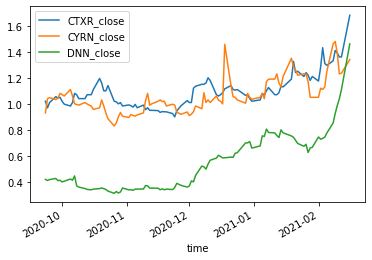

In [12]:
df_ticker.plot()

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [14]:
df_ticker_1=df_ticker.iloc[:, [0]]
df_ticker_1.head()

,CTXR_close
time,
2020-09-23 00:00:00-04:00,1.0200
2020-09-24 00:00:00-04:00,0.9692
2020-09-25 00:00:00-04:00,1.0100
2020-09-28 00:00:00-04:00,1.0550
2020-09-29 00:00:00-04:00,1.0450


In [15]:
import re
delimiters = '_'
matchPattern = ''.join(map(re.escape, delimiters))
df_ticker_1.columns = [re.split(matchPattern, i)[1] for i in df_ticker_1.columns ]
df_ticker_1.head()

,close
time,
2020-09-23 00:00:00-04:00,1.0200
2020-09-24 00:00:00-04:00,0.9692
2020-09-25 00:00:00-04:00,1.0100
2020-09-28 00:00:00-04:00,1.0550
2020-09-29 00:00:00-04:00,1.0450


<AxesSubplot:title={'center':'Returns'}, xlabel='time'>

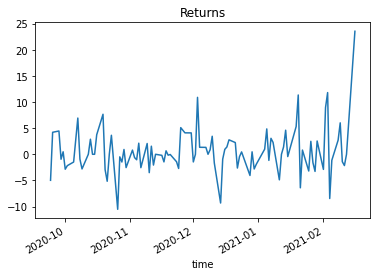

In [16]:
returns_1 = df_ticker_1.close.pct_change() * 100
returns_1.plot(title="Returns",legend=False)

In [17]:
df_ticker_1['Return'] = returns_1.copy()
df_ticker_1['Lagged_Return'] = returns_1.shift()
# Drop NaN values
df_ticker_1 = df_ticker_1.dropna()
df_ticker_1.head()

,close,Return,Lagged_Return
time,,,
2020-09-25 00:00:00-04:00,1.010,4.209657,-4.980392
2020-09-28 00:00:00-04:00,1.055,4.455446,4.209657
2020-09-29 00:00:00-04:00,1.045,-0.947867,4.455446
2020-09-30 00:00:00-04:00,1.050,0.478469,-0.947867
2020-10-01 00:00:00-04:00,1.020,-2.857143,0.478469


In [18]:
# Set y as the `Return` column
# Select the `Lagged_Return` as a DataFrame
y = df_ticker_1['Return']
X = df_ticker_1['Lagged_Return'].to_frame()

In [19]:
# Access the weekofyear attribute from the index
# Create a new column with this called `Week_of_year`
X['Week_of_year'] = X.index.weekofyear
X.head()

,Lagged_Return,Week_of_year
time,,
2020-09-25 00:00:00-04:00,-4.980392,39
2020-09-28 00:00:00-04:00,4.209657,40
2020-09-29 00:00:00-04:00,4.455446,40
2020-09-30 00:00:00-04:00,-0.947867,40
2020-10-01 00:00:00-04:00,0.478469,40


In [20]:
# Use `get_dummies` to generate the features for each week of the year
X_binary_encoded = pd.get_dummies(X, columns=['Week_of_year'])
X_binary_encoded.head()

,Lagged_Return,Week_of_year_1,Week_of_year_2,Week_of_year_3,Week_of_year_4,Week_of_year_5,Week_of_year_6,Week_of_year_7,Week_of_year_39,Week_of_year_40,...,Week_of_year_44,Week_of_year_45,Week_of_year_46,Week_of_year_47,Week_of_year_48,Week_of_year_49,Week_of_year_50,Week_of_year_51,Week_of_year_52,Week_of_year_53
time,,,,,,,,,,,,,,,,,,,,,
2020-09-25 00:00:00-04:00,-4.980392,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2020-09-28 00:00:00-04:00,4.209657,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2020-09-29 00:00:00-04:00,4.455446,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2020-09-30 00:00:00-04:00,-0.947867,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2020-10-01 00:00:00-04:00,0.478469,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Create a Linear Regression model and fit it to the data
model = LinearRegression()
model.fit(X_binary_encoded, y)

LinearRegression()

In [22]:
# List the first 10 predicted values
predictions = model.predict(X_binary_encoded)
predictions[:10]

array([ 4.20965745, -0.66676416, -0.70253399,  0.08381637, -0.12375998,
        0.36167545,  1.35783716,  1.25695388,  0.64136335,  0.03246111])

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate r2_score (r-squared)
r2 = r2_score(y, predictions)
print(f"r2: {r2}")

r2: 0.39146363390571315


In [24]:
# Calculate mean squared error 
# Remember, a "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.
mse = mean_squared_error(y, predictions)

In [25]:
# Using mean squared error above, calculate root-mean-squared error (RMSE)
rmse = np.sqrt(mse)

In [26]:
# Print the r2, mser, rmse, and standard deviation
print(f"R-squared (R2 ): {r2:0.2f}")
print(f"Mean Squared Error (MSE): {mse:0.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:0.2f}")
print(f"Standard Deviation of Futures Return: {np.std(y):0.2f}")

R-squared (R2 ): 0.39
Mean Squared Error (MSE): 12.04
Root Mean Squared Error (RMSE): 3.47
Standard Deviation of Futures Return: 4.45
